In [ ]:
# Install all packages
# Restart runtime after installation

!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [2]:
# Import all packages

import numpy as np
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [39]:
# Helper Functions


def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)

    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled


# returns the points in numpy array
def subsample_points_poisson(inputMesh, radius=4.5):
    '''
        Return sub-sampled points as numpy array.
        The radius might need to be tuned as per the requirements.
    '''
    import vtk
    from vtk.util import numpy_support

    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(radius)
    f.Update()

    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def read_landmarks(filename):
    '''
        Reads the landmarks fscv file and converts the points to correct coordinate system.
        Returns array of size N x 3
    '''
    import pandas as pd
    df = pd.read_csv(filename, comment='#', header=None)

    points_x = np.expand_dims(-1 * np.array(df[1].tolist()), -1)
    points_y = np.expand_dims(-1 * np.array(df[2].tolist()), -1)
    points_z = np.expand_dims(np.array(df[3].tolist()), -1)

    points = np.concatenate([points_x, points_y, points_z], axis=1)

    return points


def convert_vtk_pointset_to_polydata(input_pointset):
    vd = vtk.vtkPolyData()
    vd.SetPoints(input_pointset.GetPoints())
    n1 = movingMeshPoints.GetPointData().GetArray("Normals")
    vd.GetPointData().SetScalars(n1)

    # Write the polydata for testing
    vdw = vtk.vtkPolyDataWriter()
    vdw.SetFileName('test1.vtk')
    vdw.SetInputData(vd)
    vdw.SetFileTypeToASCII()
    vdw.Update()

In [34]:
# File paths

# moving mesh will remain constant
FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM174722-Cranium.ply'
MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM176211-Cranium.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [35]:
# Write the meshes in vtk format so that they can be read in ITK

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
    
    vtk_mesh = reader.GetOutput()
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [36]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []

itk_images = []
for mesh in itk_meshes:
    # Make all the points to positive coordinates
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [37]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_transformed_meshes[0]
movingMesh = itk_transformed_meshes[1]

w1 = itk.MeshFileWriter[type(fixedMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

In [47]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()


def final_iteration(fixedPoints, movingPoints, transform_type):
    '''
        Perform the final iteration of alignment
    '''
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    elif transform_type == 1:
        TransformType = itk.ScaleVersor3DTransform[itk.D]
    elif transform_type == 2:
        TransformType = itk.Similarity3DTransform[itk.D]

    transform = TransformType.New()
    transform.SetIdentity()

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    #MetricType = itk.PointToPlanePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.SetMovingTransform(transform)
    metric.Initialize()

    print('Initial Value ', metric.GetValue())
    number_of_epochs = 5000
    optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(number_of_epochs)
    optimizer.SetLearningRate(0.0001)
    optimizer.SetMinimumConvergenceValue(0.0)
    optimizer.SetConvergenceWindowSize(number_of_epochs)
    optimizer.SetMetric(metric)

    def print_iteration():
        print(f"It: {optimizer.GetCurrentIteration()}"
              f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

    optimizer.AddObserver(itk.IterationEvent(), print_iteration)
    optimizer.StartOptimization()

    print('Final Value ', metric.GetValue())

    # Get the correct transform and perform the final alignment
    current_transform = metric.GetMovingTransform().GetInverseTransform()
    itk_transformed_mesh = itk.transform_mesh_filter(
        mesh_moving, transform=current_transform)

    return itk.array_from_vector_container(itk_transformed_mesh.GetPoints())


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    '''
        Perform Ransac by doing parallel iterations for different samples.
    '''
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        '''
        Args:
            i: input seed used to sample the points.
            number_of_ransac_points: Number of random points selected to perform the registration.
            mesh_sub_sample_points: Number of points used to calculate the Euclidean distance for entire mesh.
            return_result: Whether to return the transformed mesh.
        
        Returns: (Best Value, seed) or the transformed_points depending on return_result flag.
            
        '''

        # Create Mesh inside the method to tackle the problem of serialization

        import itk

        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        # Similarity3DTransform works best when doing inter-species registration
        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]

        transform = TransformType.New()
        transform.SetIdentity()

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[
            itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits(0.1)
        optimizer.SetMinimumConvergenceValue(0.0)
        optimizer.SetConvergenceWindowSize(20)
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        #         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        #         optimizer.SetNumberOfIterations(200)
        #         optimizer.SetLearningRate(0.0001)
        #         #optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        #         optimizer.SetMinimumConvergenceValue( 0.0 )
        #         optimizer.SetConvergenceWindowSize( 200 )
        #         optimizer.SetMetric(metric)
        #         optimizer.StartOptimization()

        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            # Create a mesh using the moving points and transform it using the best transform
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))

            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)

            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)

    # Spawn multiple jobs to utilize all cores
    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))

    # Sort the results and get the best one i.e. the lowest one
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)

    return final_result


def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    print(mesh_points.shape, mesh_points.dtype)
    mesh_points = mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(
        mesh_points.flatten()))
    return input_mesh


def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh,
                                  fixedMesh):
    '''
        Perform scaling of points in the moving mesh and scale 
        the original mesh by same factor.
    '''
    sourceSize = np.linalg.norm(
        np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(
        np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize) / sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh = scale_mesh(movingMesh, scaling)

    return scaledMovingPoints, scaledMovingMesh


import time

number_of_iterations = 1000
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

# Sub-Sample the points
movingMeshPoints = subsample_points_poisson(movingMesh, radius=5.5)
fixedMeshPoints = subsample_points_poisson(fixedMesh, radius=5.5)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(
    movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

# Perform Initial alignment using Ransac parallel iterations
start_time = time.time()
transform_type = 2

itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)

# Perform final alignment using the Euler3DTransform
transform_type = 0
final_mesh = final_iteration(fixedMeshPoints, itk_transformed_points,
                             transform_type)

# Write the output 
rigidRegisteredPoints = itk.Mesh.D3.New()
rigidRegisteredPoints.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

w1 = itk.MeshFileWriter[type(rigidRegisteredPoints)].New()
w1.SetFileName('rigidRegisteredPoints.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(rigidRegisteredPoints)
w1.Update()

(5036, 3) (4886, 3)
(3557954, 3) float32
(5036, 3) 3557954
(7.906697183476345, 927)
41.07888412475586
itk_transformed_points shape  (5036, 3)
Initial Value  7.906697183476345
It: 0 metric value: 7.906697 
It: 1 metric value: 7.692641 
It: 2 metric value: 7.483346 
It: 3 metric value: 7.308514 
It: 4 metric value: 7.149157 
It: 5 metric value: 6.993083 
It: 6 metric value: 6.850487 
It: 7 metric value: 6.722918 
It: 8 metric value: 6.607136 
It: 9 metric value: 6.505393 
It: 10 metric value: 6.417376 
It: 11 metric value: 6.335397 
It: 12 metric value: 6.258026 
It: 13 metric value: 6.191851 
It: 14 metric value: 6.132154 
It: 15 metric value: 6.076945 
It: 16 metric value: 6.029378 
It: 17 metric value: 5.989075 
It: 18 metric value: 5.950028 
It: 19 metric value: 5.914796 
It: 20 metric value: 5.885458 
It: 21 metric value: 5.859391 
It: 22 metric value: 5.839675 
It: 23 metric value: 5.824741 
It: 24 metric value: 5.811881 
It: 25 metric value: 5.802178 
It: 26 metric value: 5.794472

It: 352 metric value: 5.695564 
It: 353 metric value: 5.695529 
It: 354 metric value: 5.695494 
It: 355 metric value: 5.695453 
It: 356 metric value: 5.695415 
It: 357 metric value: 5.695380 
It: 358 metric value: 5.695345 
It: 359 metric value: 5.695310 
It: 360 metric value: 5.695275 
It: 361 metric value: 5.695241 
It: 362 metric value: 5.695206 
It: 363 metric value: 5.695171 
It: 364 metric value: 5.695137 
It: 365 metric value: 5.695099 
It: 366 metric value: 5.695063 
It: 367 metric value: 5.695027 
It: 368 metric value: 5.694992 
It: 369 metric value: 5.694958 
It: 370 metric value: 5.694923 
It: 371 metric value: 5.694889 
It: 372 metric value: 5.694854 
It: 373 metric value: 5.694820 
It: 374 metric value: 5.694785 
It: 375 metric value: 5.694751 
It: 376 metric value: 5.694716 
It: 377 metric value: 5.694682 
It: 378 metric value: 5.694647 
It: 379 metric value: 5.694613 
It: 380 metric value: 5.694577 
It: 381 metric value: 5.694534 
It: 382 metric value: 5.694485 
It: 383 

It: 750 metric value: 5.681004 
It: 751 metric value: 5.680968 
It: 752 metric value: 5.680933 
It: 753 metric value: 5.680898 
It: 754 metric value: 5.680863 
It: 755 metric value: 5.680827 
It: 756 metric value: 5.680787 
It: 757 metric value: 5.680750 
It: 758 metric value: 5.680714 
It: 759 metric value: 5.680678 
It: 760 metric value: 5.680642 
It: 761 metric value: 5.680607 
It: 762 metric value: 5.680571 
It: 763 metric value: 5.680536 
It: 764 metric value: 5.680500 
It: 765 metric value: 5.680465 
It: 766 metric value: 5.680430 
It: 767 metric value: 5.680395 
It: 768 metric value: 5.680359 
It: 769 metric value: 5.680324 
It: 770 metric value: 5.680288 
It: 771 metric value: 5.680252 
It: 772 metric value: 5.680216 
It: 773 metric value: 5.680181 
It: 774 metric value: 5.680146 
It: 775 metric value: 5.680110 
It: 776 metric value: 5.680075 
It: 777 metric value: 5.680040 
It: 778 metric value: 5.680004 
It: 779 metric value: 5.679969 
It: 780 metric value: 5.679934 
It: 781 

It: 1158 metric value: 5.666651 
It: 1159 metric value: 5.666603 
It: 1160 metric value: 5.666539 
It: 1161 metric value: 5.666492 
It: 1162 metric value: 5.666451 
It: 1163 metric value: 5.666414 
It: 1164 metric value: 5.666378 
It: 1165 metric value: 5.666342 
It: 1166 metric value: 5.666307 
It: 1167 metric value: 5.666272 
It: 1168 metric value: 5.666237 
It: 1169 metric value: 5.666202 
It: 1170 metric value: 5.666167 
It: 1171 metric value: 5.666132 
It: 1172 metric value: 5.666097 
It: 1173 metric value: 5.666062 
It: 1174 metric value: 5.666027 
It: 1175 metric value: 5.665993 
It: 1176 metric value: 5.665958 
It: 1177 metric value: 5.665920 
It: 1178 metric value: 5.665875 
It: 1179 metric value: 5.665825 
It: 1180 metric value: 5.665780 
It: 1181 metric value: 5.665741 
It: 1182 metric value: 5.665701 
It: 1183 metric value: 5.665645 
It: 1184 metric value: 5.665597 
It: 1185 metric value: 5.665543 
It: 1186 metric value: 5.665493 
It: 1187 metric value: 5.665445 
It: 1188 m

It: 1558 metric value: 5.651282 
It: 1559 metric value: 5.651245 
It: 1560 metric value: 5.651208 
It: 1561 metric value: 5.651172 
It: 1562 metric value: 5.651135 
It: 1563 metric value: 5.651099 
It: 1564 metric value: 5.651062 
It: 1565 metric value: 5.651026 
It: 1566 metric value: 5.650990 
It: 1567 metric value: 5.650954 
It: 1568 metric value: 5.650918 
It: 1569 metric value: 5.650882 
It: 1570 metric value: 5.650845 
It: 1571 metric value: 5.650809 
It: 1572 metric value: 5.650773 
It: 1573 metric value: 5.650737 
It: 1574 metric value: 5.650701 
It: 1575 metric value: 5.650665 
It: 1576 metric value: 5.650629 
It: 1577 metric value: 5.650588 
It: 1578 metric value: 5.650549 
It: 1579 metric value: 5.650509 
It: 1580 metric value: 5.650459 
It: 1581 metric value: 5.650411 
It: 1582 metric value: 5.650366 
It: 1583 metric value: 5.650327 
It: 1584 metric value: 5.650279 
It: 1585 metric value: 5.650224 
It: 1586 metric value: 5.650175 
It: 1587 metric value: 5.650134 
It: 1588 m

It: 1955 metric value: 5.636616 
It: 1956 metric value: 5.636562 
It: 1957 metric value: 5.636519 
It: 1958 metric value: 5.636479 
It: 1959 metric value: 5.636433 
It: 1960 metric value: 5.636382 
It: 1961 metric value: 5.636337 
It: 1962 metric value: 5.636294 
It: 1963 metric value: 5.636255 
It: 1964 metric value: 5.636209 
It: 1965 metric value: 5.636161 
It: 1966 metric value: 5.636115 
It: 1967 metric value: 5.636072 
It: 1968 metric value: 5.636033 
It: 1969 metric value: 5.635996 
It: 1970 metric value: 5.635960 
It: 1971 metric value: 5.635924 
It: 1972 metric value: 5.635888 
It: 1973 metric value: 5.635852 
It: 1974 metric value: 5.635817 
It: 1975 metric value: 5.635781 
It: 1976 metric value: 5.635746 
It: 1977 metric value: 5.635710 
It: 1978 metric value: 5.635675 
It: 1979 metric value: 5.635640 
It: 1980 metric value: 5.635604 
It: 1981 metric value: 5.635569 
It: 1982 metric value: 5.635534 
It: 1983 metric value: 5.635498 
It: 1984 metric value: 5.635463 
It: 1985 m

It: 2343 metric value: 5.622327 
It: 2344 metric value: 5.622292 
It: 2345 metric value: 5.622258 
It: 2346 metric value: 5.622223 
It: 2347 metric value: 5.622189 
It: 2348 metric value: 5.622154 
It: 2349 metric value: 5.622120 
It: 2350 metric value: 5.622085 
It: 2351 metric value: 5.622051 
It: 2352 metric value: 5.622016 
It: 2353 metric value: 5.621982 
It: 2354 metric value: 5.621947 
It: 2355 metric value: 5.621913 
It: 2356 metric value: 5.621878 
It: 2357 metric value: 5.621844 
It: 2358 metric value: 5.621809 
It: 2359 metric value: 5.621775 
It: 2360 metric value: 5.621740 
It: 2361 metric value: 5.621706 
It: 2362 metric value: 5.621671 
It: 2363 metric value: 5.621636 
It: 2364 metric value: 5.621602 
It: 2365 metric value: 5.621567 
It: 2366 metric value: 5.621533 
It: 2367 metric value: 5.621498 
It: 2368 metric value: 5.621464 
It: 2369 metric value: 5.621429 
It: 2370 metric value: 5.621395 
It: 2371 metric value: 5.621360 
It: 2372 metric value: 5.621326 
It: 2373 m

It: 2729 metric value: 5.609196 
It: 2730 metric value: 5.609163 
It: 2731 metric value: 5.609129 
It: 2732 metric value: 5.609095 
It: 2733 metric value: 5.609061 
It: 2734 metric value: 5.609028 
It: 2735 metric value: 5.608994 
It: 2736 metric value: 5.608960 
It: 2737 metric value: 5.608927 
It: 2738 metric value: 5.608893 
It: 2739 metric value: 5.608859 
It: 2740 metric value: 5.608825 
It: 2741 metric value: 5.608792 
It: 2742 metric value: 5.608758 
It: 2743 metric value: 5.608729 
It: 2744 metric value: 5.608696 
It: 2745 metric value: 5.608666 
It: 2746 metric value: 5.608634 
It: 2747 metric value: 5.608605 
It: 2748 metric value: 5.608573 
It: 2749 metric value: 5.608540 
It: 2750 metric value: 5.608507 
It: 2751 metric value: 5.608471 
It: 2752 metric value: 5.608437 
It: 2753 metric value: 5.608402 
It: 2754 metric value: 5.608368 
It: 2755 metric value: 5.608335 
It: 2756 metric value: 5.608301 
It: 2757 metric value: 5.608267 
It: 2758 metric value: 5.608233 
It: 2759 m

It: 3126 metric value: 5.595972 
It: 3127 metric value: 5.595936 
It: 3128 metric value: 5.595902 
It: 3129 metric value: 5.595869 
It: 3130 metric value: 5.595835 
It: 3131 metric value: 5.595803 
It: 3132 metric value: 5.595770 
It: 3133 metric value: 5.595737 
It: 3134 metric value: 5.595705 
It: 3135 metric value: 5.595672 
It: 3136 metric value: 5.595639 
It: 3137 metric value: 5.595605 
It: 3138 metric value: 5.595572 
It: 3139 metric value: 5.595539 
It: 3140 metric value: 5.595506 
It: 3141 metric value: 5.595460 
It: 3142 metric value: 5.595421 
It: 3143 metric value: 5.595386 
It: 3144 metric value: 5.595352 
It: 3145 metric value: 5.595319 
It: 3146 metric value: 5.595286 
It: 3147 metric value: 5.595253 
It: 3148 metric value: 5.595220 
It: 3149 metric value: 5.595187 
It: 3150 metric value: 5.595154 
It: 3151 metric value: 5.595122 
It: 3152 metric value: 5.595090 
It: 3153 metric value: 5.595057 
It: 3154 metric value: 5.595026 
It: 3155 metric value: 5.594994 
It: 3156 m

It: 3522 metric value: 5.582991 
It: 3523 metric value: 5.582956 
It: 3524 metric value: 5.582917 
It: 3525 metric value: 5.582881 
It: 3526 metric value: 5.582847 
It: 3527 metric value: 5.582813 
It: 3528 metric value: 5.582780 
It: 3529 metric value: 5.582746 
It: 3530 metric value: 5.582713 
It: 3531 metric value: 5.582677 
It: 3532 metric value: 5.582642 
It: 3533 metric value: 5.582608 
It: 3534 metric value: 5.582575 
It: 3535 metric value: 5.582542 
It: 3536 metric value: 5.582511 
It: 3537 metric value: 5.582478 
It: 3538 metric value: 5.582445 
It: 3539 metric value: 5.582412 
It: 3540 metric value: 5.582379 
It: 3541 metric value: 5.582346 
It: 3542 metric value: 5.582313 
It: 3543 metric value: 5.582280 
It: 3544 metric value: 5.582247 
It: 3545 metric value: 5.582214 
It: 3546 metric value: 5.582180 
It: 3547 metric value: 5.582147 
It: 3548 metric value: 5.582114 
It: 3549 metric value: 5.582081 
It: 3550 metric value: 5.582048 
It: 3551 metric value: 5.582008 
It: 3552 m

It: 3915 metric value: 5.570100 
It: 3916 metric value: 5.570065 
It: 3917 metric value: 5.570031 
It: 3918 metric value: 5.569997 
It: 3919 metric value: 5.569964 
It: 3920 metric value: 5.569930 
It: 3921 metric value: 5.569897 
It: 3922 metric value: 5.569864 
It: 3923 metric value: 5.569830 
It: 3924 metric value: 5.569797 
It: 3925 metric value: 5.569763 
It: 3926 metric value: 5.569730 
It: 3927 metric value: 5.569696 
It: 3928 metric value: 5.569663 
It: 3929 metric value: 5.569630 
It: 3930 metric value: 5.569599 
It: 3931 metric value: 5.569567 
It: 3932 metric value: 5.569536 
It: 3933 metric value: 5.569503 
It: 3934 metric value: 5.569468 
It: 3935 metric value: 5.569426 
It: 3936 metric value: 5.569389 
It: 3937 metric value: 5.569354 
It: 3938 metric value: 5.569321 
It: 3939 metric value: 5.569287 
It: 3940 metric value: 5.569253 
It: 3941 metric value: 5.569219 
It: 3942 metric value: 5.569186 
It: 3943 metric value: 5.569152 
It: 3944 metric value: 5.569119 
It: 3945 m

It: 4313 metric value: 5.556773 
It: 4314 metric value: 5.556739 
It: 4315 metric value: 5.556706 
It: 4316 metric value: 5.556673 
It: 4317 metric value: 5.556640 
It: 4318 metric value: 5.556598 
It: 4319 metric value: 5.556562 
It: 4320 metric value: 5.556528 
It: 4321 metric value: 5.556494 
It: 4322 metric value: 5.556461 
It: 4323 metric value: 5.556428 
It: 4324 metric value: 5.556396 
It: 4325 metric value: 5.556363 
It: 4326 metric value: 5.556331 
It: 4327 metric value: 5.556298 
It: 4328 metric value: 5.556265 
It: 4329 metric value: 5.556232 
It: 4330 metric value: 5.556199 
It: 4331 metric value: 5.556166 
It: 4332 metric value: 5.556133 
It: 4333 metric value: 5.556106 
It: 4334 metric value: 5.556076 
It: 4335 metric value: 5.556044 
It: 4336 metric value: 5.556012 
It: 4337 metric value: 5.555979 
It: 4338 metric value: 5.555946 
It: 4339 metric value: 5.555913 
It: 4340 metric value: 5.555880 
It: 4341 metric value: 5.555847 
It: 4342 metric value: 5.555814 
It: 4343 m

It: 4718 metric value: 5.543534 
It: 4719 metric value: 5.543501 
It: 4720 metric value: 5.543470 
It: 4721 metric value: 5.543439 
It: 4722 metric value: 5.543406 
It: 4723 metric value: 5.543367 
It: 4724 metric value: 5.543332 
It: 4725 metric value: 5.543298 
It: 4726 metric value: 5.543265 
It: 4727 metric value: 5.543232 
It: 4728 metric value: 5.543200 
It: 4729 metric value: 5.543167 
It: 4730 metric value: 5.543134 
It: 4731 metric value: 5.543102 
It: 4732 metric value: 5.543072 
It: 4733 metric value: 5.543041 
It: 4734 metric value: 5.543009 
It: 4735 metric value: 5.542966 
It: 4736 metric value: 5.542930 
It: 4737 metric value: 5.542890 
It: 4738 metric value: 5.542855 
It: 4739 metric value: 5.542821 
It: 4740 metric value: 5.542787 
It: 4741 metric value: 5.542753 
It: 4742 metric value: 5.542719 
It: 4743 metric value: 5.542686 
It: 4744 metric value: 5.542654 
It: 4745 metric value: 5.542621 
It: 4746 metric value: 5.542588 
It: 4747 metric value: 5.542555 
It: 4748 m

In [ ]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

view(point_sets=[fixedMeshPoints, movingMeshPoints, final_mesh])

In [56]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))


# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 12
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()

# Registration Loop
numOfIterations = 5000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)


def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()

# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ',
      e_metric.GetValue())

movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPpran
S.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ',
      e_metric.GetValue())

# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

Spacing  3.5016411888748684
minBounds  [ -78.53991699  -82.48506927 -135.99531555]
maxBounds  [ 62.59847641  81.81204987 139.1434021 ]
Metric Created
Metric: -0.05441236
Metric: -0.054415
Metric: -0.054417612
Metric: -0.054420194
Metric: -0.05442275
Metric: -0.054425279
Metric: -0.054427787
Metric: -0.054430277
Metric: -0.054432752
Metric: -0.05443522
Metric: -0.05443769
Metric: -0.054440172
Metric: -0.054442673
Metric: -0.054445202
Metric: -0.054447769
Metric: -0.054450382
Metric: -0.054453045
Metric: -0.054455812
Metric: -0.054458634
Metric: -0.054461508
Metric: -0.054464428
Metric: -0.054467393
Metric: -0.054470397
Metric: -0.054473445
Metric: -0.054476537
Metric: -0.054479681
Metric: -0.054482884
Metric: -0.054486158
Metric: -0.054489509
Metric: -0.054492951
Metric: -0.054496493
Metric: -0.05450014
Metric: -0.054503907
Metric: -0.054507797
Metric: -0.054511818
Metric: -0.054515979
Metric: -0.054520283
Metric: -0.054524733
Metric: -0.054529331
Metric: -0.054534075
Metric: -0.0545389

Metric: -0.057521007
Metric: -0.057530288
Metric: -0.057539579
Metric: -0.057548883
Metric: -0.057558198
Metric: -0.057567527
Metric: -0.057576869
Metric: -0.057586226
Metric: -0.057595598
Metric: -0.057604987
Metric: -0.057614391
Metric: -0.057623812
Metric: -0.057633252
Metric: -0.057642711
Metric: -0.057652188
Metric: -0.057661685
Metric: -0.057671202
Metric: -0.05768074
Metric: -0.0576903
Metric: -0.057699883
Metric: -0.057709489
Metric: -0.057719119
Metric: -0.057728773
Metric: -0.057738453
Metric: -0.057748159
Metric: -0.057757893
Metric: -0.057767654
Metric: -0.057777442
Metric: -0.05778726
Metric: -0.057797106
Metric: -0.057806983
Metric: -0.05781689
Metric: -0.057826828
Metric: -0.057836799
Metric: -0.057846803
Metric: -0.057856839
Metric: -0.05786691
Metric: -0.057877015
Metric: -0.057887156
Metric: -0.057897334
Metric: -0.057907547
Metric: -0.057917799
Metric: -0.057928088
Metric: -0.057938415
Metric: -0.057948783
Metric: -0.057959188
Metric: -0.057969634
Metric: -0.05798012

Metric: -0.062714244
Metric: -0.06272899
Metric: -0.062743751
Metric: -0.062758521
Metric: -0.062773305
Metric: -0.062788101
Metric: -0.062802913
Metric: -0.062817736
Metric: -0.062832571
Metric: -0.062847419
Metric: -0.06286228
Metric: -0.062877156
Metric: -0.062892043
Metric: -0.062906944
Metric: -0.062921858
Metric: -0.062936783
Metric: -0.062951723
Metric: -0.062966674
Metric: -0.06298164
Metric: -0.062996618
Metric: -0.063011609
Metric: -0.063026612
Metric: -0.06304163
Metric: -0.063056662
Metric: -0.063071704
Metric: -0.06308676
Metric: -0.063101827
Metric: -0.063116906
Metric: -0.063131997
Metric: -0.063147098
Metric: -0.063162212
Metric: -0.063177338
Metric: -0.063192473
Metric: -0.063207622
Metric: -0.06322278
Metric: -0.063237948
Metric: -0.063253128
Metric: -0.063268319
Metric: -0.063283517
Metric: -0.063298725
Metric: -0.063313945
Metric: -0.063329174
Metric: -0.063344413
Metric: -0.06335966
Metric: -0.063374917
Metric: -0.063390182
Metric: -0.063405457
Metric: -0.063420741

Metric: -0.068543042
Metric: -0.068556143
Metric: -0.06856921
Metric: -0.068582247
Metric: -0.068595254
Metric: -0.068608229
Metric: -0.068621177
Metric: -0.068634098
Metric: -0.068646994
Metric: -0.068659868
Metric: -0.068672721
Metric: -0.068685557
Metric: -0.068698381
Metric: -0.068711194
Metric: -0.068724003
Metric: -0.068736811
Metric: -0.068749625
Metric: -0.068762447
Metric: -0.068775287
Metric: -0.068788149
Metric: -0.06880104
Metric: -0.068813966
Metric: -0.068826934
Metric: -0.068839952
Metric: -0.068853026
Metric: -0.068866166
Metric: -0.068879381
Metric: -0.068892675
Metric: -0.068906058
Metric: -0.068919539
Metric: -0.068933124
Metric: -0.068946823
Metric: -0.068960644
Metric: -0.068974592
Metric: -0.068988678
Metric: -0.069002907
Metric: -0.069017289
Metric: -0.069031825
Metric: -0.069046526
Metric: -0.069061394
Metric: -0.069076437
Metric: -0.069091656
Metric: -0.069107056
Metric: -0.069122636
Metric: -0.069138401
Metric: -0.069154364
Metric: -0.069170506
Metric: -0.0691

Metric: -0.075384121
Metric: -0.075401034
Metric: -0.075417939
Metric: -0.075434833
Metric: -0.07545172
Metric: -0.075468596
Metric: -0.075485462
Metric: -0.075502319
Metric: -0.075519166
Metric: -0.075536004
Metric: -0.075552835
Metric: -0.075569653
Metric: -0.075586463
Metric: -0.075603263
Metric: -0.075620052
Metric: -0.075636831
Metric: -0.0756536
Metric: -0.075670359
Metric: -0.075687109
Metric: -0.075703848
Metric: -0.075720576
Metric: -0.075737295
Metric: -0.075754
Metric: -0.075770698
Metric: -0.075787383
Metric: -0.075804058
Metric: -0.075820724
Metric: -0.075837376
Metric: -0.075854019
Metric: -0.075870649
Metric: -0.075887268
Metric: -0.075903876
Metric: -0.075920472
Metric: -0.075937057
Metric: -0.075953628
Metric: -0.075970189
Metric: -0.075986737
Metric: -0.076003272
Metric: -0.076019794
Metric: -0.076036305
Metric: -0.076052803
Metric: -0.076069287
Metric: -0.076085759
Metric: -0.076102217
Metric: -0.076118662
Metric: -0.076135093
Metric: -0.076151512
Metric: -0.07616791

Metric: -0.080466122
Metric: -0.08048004
Metric: -0.08049394
Metric: -0.08050782
Metric: -0.080521682
Metric: -0.080535524
Metric: -0.080549348
Metric: -0.080563151
Metric: -0.080576938
Metric: -0.080590703
Metric: -0.08060445
Metric: -0.080618178
Metric: -0.080631886
Metric: -0.080645575
Metric: -0.080659245
Metric: -0.080672896
Metric: -0.080686525
Metric: -0.080700136
Metric: -0.080713727
Metric: -0.080727299
Metric: -0.080740848
Metric: -0.080754382
Metric: -0.080767895
Metric: -0.080781388
Metric: -0.080794862
Metric: -0.080808316
Metric: -0.08082175
Metric: -0.080835164
Metric: -0.080848558
Metric: -0.080861932
Metric: -0.080875287
Metric: -0.080888622
Metric: -0.080901937
Metric: -0.080915231
Metric: -0.080928507
Metric: -0.080941764
Metric: -0.080954999
Metric: -0.080968215
Metric: -0.080981411
Metric: -0.080994587
Metric: -0.081007743
Metric: -0.081020879
Metric: -0.081033997
Metric: -0.081047092
Metric: -0.081060169
Metric: -0.081073227
Metric: -0.081086263
Metric: -0.0810992

Metric: -0.084859168
Metric: -0.084867979
Metric: -0.084876776
Metric: -0.084885565
Metric: -0.084894342
Metric: -0.084903107
Metric: -0.084911861
Metric: -0.084920606
Metric: -0.084929338
Metric: -0.084938059
Metric: -0.084946768
Metric: -0.084955467
Metric: -0.084964154
Metric: -0.08497283
Metric: -0.084981496
Metric: -0.08499015
Metric: -0.084998794
Metric: -0.085007424
Metric: -0.085016045
Metric: -0.085024655
Metric: -0.085033252
Metric: -0.085041842
Metric: -0.085050419
Metric: -0.085058983
Metric: -0.085067539
Metric: -0.085076084
Metric: -0.085084617
Metric: -0.085093139
Metric: -0.085101652
Metric: -0.085110153
Metric: -0.085118644
Metric: -0.085127125
Metric: -0.085135595
Metric: -0.085144057
Metric: -0.085152507
Metric: -0.085160947
Metric: -0.085169378
Metric: -0.085177799
Metric: -0.085186211
Metric: -0.085194612
Metric: -0.085203005
Metric: -0.085211391
Metric: -0.085219766
Metric: -0.085228132
Metric: -0.08523649
Metric: -0.08524484
Metric: -0.085253181
Metric: -0.085261

Metric: -0.08762753
Metric: -0.087635055
Metric: -0.087642573
Metric: -0.087650085
Metric: -0.08765759
Metric: -0.087665087
Metric: -0.08767258
Metric: -0.087680065
Metric: -0.087687546
Metric: -0.08769502
Metric: -0.087702487
Metric: -0.087709947
Metric: -0.087717404
Metric: -0.087724851
Metric: -0.087732295
Metric: -0.087739731
Metric: -0.087747161
Metric: -0.087754588
Metric: -0.087762007
Metric: -0.087769419
Metric: -0.087776827
Metric: -0.087784228
Metric: -0.087791624
Metric: -0.087799018
Metric: -0.087806406
Metric: -0.087813786
Metric: -0.087821164
Metric: -0.087828534
Metric: -0.087835901
Metric: -0.087843259
Metric: -0.087850613
Metric: -0.087857963
Metric: -0.087865305
Metric: -0.087872643
Metric: -0.087879975
Metric: -0.087887302
Metric: -0.087894623
Metric: -0.087901939
Metric: -0.08790925
Metric: -0.087916555
Metric: -0.087923854
Metric: -0.087931148
Metric: -0.087938436
Metric: -0.087945719
Metric: -0.087952998
Metric: -0.08796027
Metric: -0.087967539
Metric: -0.08797480

Metric: -0.090089125
Metric: -0.09009523
Metric: -0.090101346
Metric: -0.090107471
Metric: -0.090113606
Metric: -0.090119752
Metric: -0.090125904
Metric: -0.090132065
Metric: -0.090138234
Metric: -0.090144409
Metric: -0.090150589
Metric: -0.090156777
Metric: -0.090162969
Metric: -0.090169166
Metric: -0.090175368
Metric: -0.090181574
Metric: -0.090187785
Metric: -0.090193999
Metric: -0.090200217
Metric: -0.090206437
Metric: -0.090212661
Metric: -0.090218887
Metric: -0.090225115
Metric: -0.090231345
Metric: -0.090237575
Metric: -0.090243809
Metric: -0.090250044
Metric: -0.09025628
Metric: -0.090262516
Metric: -0.090268753
Metric: -0.090274992
Metric: -0.090281233
Metric: -0.090287471
Metric: -0.090293711
Metric: -0.090299951
Metric: -0.090306191
Metric: -0.090312431
Metric: -0.09031867
Metric: -0.09032491
Metric: -0.090331149
Metric: -0.090337387
Metric: -0.090343625
Metric: -0.090349864
Metric: -0.090356102
Metric: -0.090362339
Metric: -0.090368576
Metric: -0.090374812
Metric: -0.090381

Metric: -0.092497003
Metric: -0.092501906
Metric: -0.092506811
Metric: -0.092511723
Metric: -0.092516638
Metric: -0.092521557
Metric: -0.09252648
Metric: -0.092531408
Metric: -0.09253634
Metric: -0.092541277
Metric: -0.092546218
Metric: -0.092551162
Metric: -0.092556109
Metric: -0.092561063
Metric: -0.092566017
Metric: -0.092570973
Metric: -0.092575934
Metric: -0.092580895
Metric: -0.092585861
Metric: -0.092590829
Metric: -0.092595798
Metric: -0.092600771
Metric: -0.092605745
Metric: -0.09261072
Metric: -0.092615696
Metric: -0.092620674
Metric: -0.092625651
Metric: -0.092630633
Metric: -0.092635612
Metric: -0.092640593
Metric: -0.092645574
Metric: -0.092650548
Metric: -0.092655523
Metric: -0.092660499
Metric: -0.092665476
Metric: -0.092670451
Metric: -0.092675427
Metric: -0.092680402
Metric: -0.092685379
Metric: -0.092690356
Metric: -0.092695329
Metric: -0.092700302
Metric: -0.092705273
Metric: -0.092710243
Metric: -0.092715212
Metric: -0.092720181
Metric: -0.092725148
Metric: -0.09273

Metric: -0.094388585
Metric: -0.094392404
Metric: -0.094396246
Metric: -0.094400106
Metric: -0.094403986
Metric: -0.094407883
Metric: -0.094411796
Metric: -0.094415725
Metric: -0.09441967
Metric: -0.094423627
Metric: -0.094427597
Metric: -0.094431577
Metric: -0.094435572
Metric: -0.094439575
Metric: -0.094443587
Metric: -0.094447606
Metric: -0.09445163
Metric: -0.094455659
Metric: -0.094459693
Metric: -0.09446373
Metric: -0.094467769
Metric: -0.094471812
Metric: -0.094475855
Metric: -0.094479898
Metric: -0.094483942
Metric: -0.094487986
Metric: -0.094492027
Metric: -0.094496066
Metric: -0.094500104
Metric: -0.094504141
Metric: -0.094508172
Metric: -0.094512201
Metric: -0.094516226
Metric: -0.094520248
Metric: -0.094524266
Metric: -0.094528279
Metric: -0.094532288
Metric: -0.094536292
Metric: -0.094540291
Metric: -0.094544283
Metric: -0.094548272
Metric: -0.094552255
Metric: -0.094556231
Metric: -0.094560202
Metric: -0.094564169
Metric: -0.094568129
Metric: -0.094572083
Metric: -0.09457

Metric: -0.095613998
Metric: -0.09561789
Metric: -0.095621784
Metric: -0.095625678
Metric: -0.095629577
Metric: -0.095633477
Metric: -0.095637381
Metric: -0.095641287
Metric: -0.095645195
Metric: -0.095649106
Metric: -0.095653019
Metric: -0.095656934
Metric: -0.095660849
Metric: -0.095664768
Metric: -0.095668687
Metric: -0.095672609
Metric: -0.095676536
Metric: -0.095680462
Metric: -0.095684391
Metric: -0.09568832
Metric: -0.095692251
Metric: -0.095696182
Metric: -0.095700115
Metric: -0.095704051
Metric: -0.095707985
Metric: -0.095711921
Metric: -0.095715858
Metric: -0.095719796
Metric: -0.095723735
Metric: -0.095727674
Metric: -0.09573161
Metric: -0.095735551
Metric: -0.09573949
Metric: -0.095743428
Metric: -0.095747367
Metric: -0.095751303
Metric: -0.095755243
Metric: -0.095759179
Metric: -0.095763118
Metric: -0.095767055
Metric: -0.095770991
Metric: -0.095774927
Metric: -0.095778861
Metric: -0.095782795
Metric: -0.095786726
Metric: -0.095790656
Metric: -0.095794584
Metric: -0.095798

Metric: -0.096258627
Metric: -0.096263038
Metric: -0.096267444
Metric: -0.096271842
Metric: -0.096276235
Metric: -0.096280621
Metric: -0.096285
Metric: -0.096289373
Metric: -0.096293738
Metric: -0.096298097
Metric: -0.096302449
Metric: -0.096306794
Metric: -0.096311132
Metric: -0.096315464
Metric: -0.096319789
Metric: -0.096324107
Metric: -0.096328417
Metric: -0.096332719
Metric: -0.096337016
Metric: -0.096341307
Metric: -0.096345589
Metric: -0.096349866
Metric: -0.096354134
Metric: -0.096358396
Metric: -0.096362651
Metric: -0.096366901
Metric: -0.096371141
Metric: -0.096375379
Metric: -0.096379608
Metric: -0.09638383
Metric: -0.096388047
Metric: -0.096392257
Metric: -0.096396462
Metric: -0.096400661
Metric: -0.096404854
Metric: -0.09640904
Metric: -0.096413222
Metric: -0.096417397
Metric: -0.096421566
Metric: -0.096425729
Metric: -0.096429888
Metric: -0.096434041
Metric: -0.096438189
Metric: -0.096442332
Metric: -0.096446469
Metric: -0.096450602
Metric: -0.096454729
Metric: -0.0964588

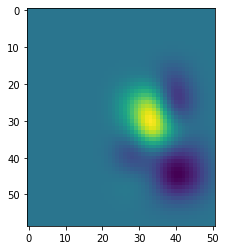

In [57]:
plt.imshow(field[15, :, :, 2])

In [98]:
# Write the meshes

movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source model(rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = itk.meshread(movingMeshPath)
for i in range(0, movingMesh.GetNumberOfPoints()):
    movingMesh.SetPoint(i, final_transform.TransformPoint(movingMesh.GetPoint(i)))

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh_itk1.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()


In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
                         
for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

In [81]:
movingMesh_itk_np = itk.array_from_vector_container(movingMesh.GetPoints())
print(movingMesh_itk_np.shape)

(2351553, 3)


In [92]:
test1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.vtk')
test2 = readvtk('movingMesh_itk.vtk')
test3 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/TPS Warped source model_1.vtk')

itkwidgets.view(geometries=[test1, test2, test3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [72]:
movingPS_np = itk.array_from_vector_container(movingPS.GetPoints())
fixedPS_np = itk.array_from_vector_container(fixedPS.GetPoints())
movingPSNew_np = itk.array_from_vector_container(movingPSNew.GetPoints())

itkwidgets.view(point_sets=[movingPS_np, movingPSNew_np, fixedPS_np])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

(55, 94, 64, 3)


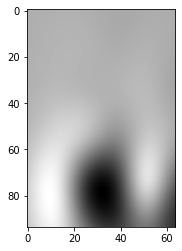

In [18]:
# Visualize the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')